# Loading the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [3]:
date_cols = ['Date']
df = pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/clean_data_set_2.csv", dtype={'Account':str}, index_col=0, parse_dates=date_cols)
df.head()

,Account,Amount,Balance,to_account,to_name,Date,Time,Transaction_ID,Decimal_time,Income,Employment,Day_type,Day
0,1461,1352.0,2582.04,1379.0,Starbucks,2020-01-01,00:00:00,0,0.0,2811.08,Employed,weekday,Wednesday
1,1088,1251.2,2285.19,1244.0,Adams,2020-01-01,00:00:00,1,0.0,2603.54,Employed,weekday,Wednesday
2,1447,1968.5,2479.09,1101.0,North Face,2020-01-01,00:00:00,2,0.0,4043.70,Employed,weekday,Wednesday
3,1207,1352.0,2530.55,1178.0,Coffee #1,2020-01-01,00:00:00,3,0.0,2768.97,Employed,weekday,Wednesday
4,1136,1968.5,3627.45,1305.0,Cass Art,2020-01-01,00:00:00,4,0.0,3975.15,Employed,weekday,Wednesday


### Any obvious outliers?

In [159]:
from sklearn.ensemble import IsolationForest
anomalies_df_obv = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_obv[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
iForest=IsolationForest(n_estimators=100,max_features=1.0)
iForest.fit(np.array(df['Amount']).reshape(-1,1)) 
anomalies_df_obv['anomaly']=iForest.predict(np.array(df['Amount']).reshape(-1,1))

anomalies_obv = df[anomalies_df_obv['anomaly'] == -1]['Amount']
nonanomalies_obv = df[anomalies_df_obv['anomaly'] == 1]['Amount']


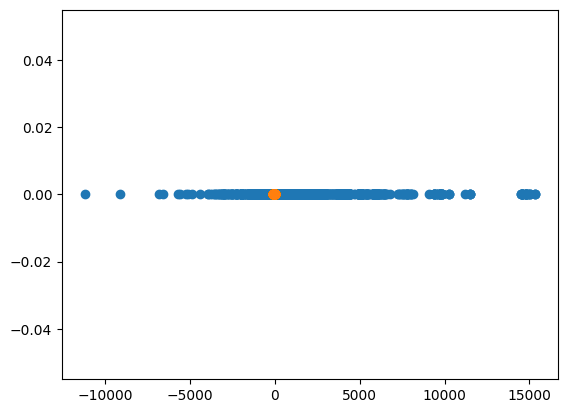

In [155]:

plt.scatter(np.array(anomalies_obv), np.zeros_like(anomalies_obv))
plt.scatter(np.array(nonanomalies_obv), np.zeros_like(nonanomalies_obv))
plt.show()

# Adding features

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174601 entries, 0 to 174600
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Account         174601 non-null  object        
 1   Amount          174601 non-null  float64       
 2   Balance         174601 non-null  float64       
 3   to_account      174601 non-null  object        
 4   to_name         174601 non-null  object        
 5   Date            174601 non-null  datetime64[ns]
 6   Time            174601 non-null  object        
 7   Transaction_ID  174601 non-null  int64         
 8   Decimal_time    174601 non-null  float64       
 9   Income          95107 non-null   float64       
 10  Employment      174601 non-null  object        
 11  Day_type        174601 non-null  object        
 12  Day             174601 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(7)
memory usage: 18.6+ MB


In [4]:
df = df[df.Amount < 0]

In [5]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()  
transformed = ohe.fit_transform(df[['Day_type']])
df[ohe.categories_[0]] = transformed.toarray()

In [6]:
bank_holiday_indexes = df[(df.Date == '2020-01-01')].index
df.loc[bank_holiday_indexes, "weekday"] = 0
df.drop(['Day_type', 'weekend'], axis = 1, inplace= True)

In [7]:
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)


In [8]:
df['Absoulute_time'] = df['Date'].apply(lambda x: ((((x.month-1)*31)+(x.day-1))*24) if x.month != 3 else ((((28+31)+(x.day-1))*24)))
df['Absoulute_time'] = df['Absoulute_time']+ df['Decimal_time']

### The following features trens and time_diff are from my research they allow us to bring as much information possible into our model

In [9]:
df['Trend'] = 0
df['Time_diff'] = 0
customer_list  = df.Account.unique()
for customer in customer_list:
    customer_indexes = df[(df['Account'] == customer)].index
    temp_df = df[df.Account == customer][['Amount', 'Trend', 'Absoulute_time', 'Time_diff']]
    temp_df['Trend'] = -temp_df['Amount'].diff(1)/temp_df.Amount.shift(1)
    temp_df['Time_diff'] = temp_df['Absoulute_time'].diff(1)
    df.loc[customer_indexes, "Trend"] = temp_df.Trend
    df.loc[customer_indexes, "Time_diff"] = temp_df.Time_diff

In [10]:
df['Trend']=df['Trend'].fillna(0)
df['Time_diff']=df['Time_diff'].fillna(0)

In [11]:
buisness_spenniness = df.groupby('to_name').agg({'Amount': np.mean}).reset_index()
list_of_means = np.array(buisness_spenniness['Amount'])
buisness_spenniness['percentile_of_business']= buisness_spenniness['Amount'].apply(lambda x: round(stats.percentileofscore(list_of_means, x), -1))

In [12]:
df = pd.merge(df, buisness_spenniness[['to_name', 'percentile_of_business']], on='to_name')

# Fraud detection by running an fraud detection algorithm directly on each accounts transaction data
### We must visualise/checl what the algorithms are doing to see if they are picking out reasonable anomalies
- Isolation forests
- SVM
- LOF
- Voting system combining the 3 above

### Pre-processing

In [215]:
df.columns

Index(['Account', 'Amount', 'Balance', 'to_account', 'to_name', 'Date', 'Time',
       'Transaction_ID', 'Decimal_time', 'Income', 'Employment', 'Day',
       'weekday', 'Month', 'Absoulute_time', 'Trend', 'Time_diff',
       'percentile_of_business'],
      dtype='object')

In [13]:
from sklearn import preprocessing
df_fraud = df.drop(['Account', 'to_account', 'to_name', 'Date', 'Time', 'Transaction_ID', 'Employment', 'Income', 'Day', 'Month', 'Absoulute_time'], axis=1)

std_scale = preprocessing.StandardScaler().fit(df_fraud)
train_norm = std_scale.transform(df_fraud)
training_norm_col = pd.DataFrame(train_norm, index=df_fraud.index, columns=df_fraud.columns) 
df_fraud.update(training_norm_col)
df_fraud.head()

,Amount,Balance,Decimal_time,weekday,Trend,Time_diff,percentile_of_business
0,-7.502333,0.843403,-2.552375,-1.46307,0.17712,-0.669006,-2.166367
1,-7.043132,0.822288,-2.552375,-1.46307,0.17712,-0.669006,-2.166367
2,-4.287927,0.572581,-2.552375,-1.46307,0.17712,-0.669006,-2.166367
3,-5.206329,0.891412,-2.552375,-1.46307,0.17712,-0.669006,-2.166367
4,-6.813532,0.896536,-2.552375,-1.46307,0.17712,-0.669006,-2.166367


# Isolation forests

In [14]:
from sklearn.ensemble import IsolationForest
anomalies_df_IF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_IF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
iForest=IsolationForest(n_estimators=100,max_features=1.0)
iForest.fit(temp) 
anomalies_df_IF['scores']=iForest.decision_function(temp)
anomalies_df_IF['anomaly']=iForest.predict(temp)


In [15]:
print(anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0] + anomalies_df_IF[anomalies_df_IF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_IF[anomalies_df_IF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.10974245467996295 proportion of the data as anomalies


### Isoloation forests gives 14% of the data as anomalies

# One class SVM

In [23]:
from sklearn.svm import OneClassSVM
anomalies_df_SVM = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_SVM[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
ocsvm=OneClassSVM()
ocsvm.fit(temp) 
anomalies_df_SVM['scores']=ocsvm.decision_function(temp)
anomalies_df_SVM['anomaly']=ocsvm.predict(temp)


In [30]:
print(anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0] + anomalies_df_SVM[anomalies_df_SVM.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_SVM[anomalies_df_SVM.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.5 proportion of the data as anomalies


### 50% of the data is classified as anomalous, this is of course way too high

# LOF (Local Oulier Factor)

In [16]:
from sklearn.neighbors import LocalOutlierFactor
anomalies_df_LOF = pd.DataFrame(columns=['Account', 'Transaction_ID', 'scores', 'anomaly'])
anomalies_df_LOF[['Account', 'Transaction_ID']] = df[['Account', 'Transaction_ID']]
temp = df_fraud
lof=LocalOutlierFactor(novelty=True)
lof.fit(temp) 
anomalies_df_LOF['scores']=lof.decision_function(temp)
anomalies_df_LOF['anomaly']=lof.predict(temp)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [17]:
print(anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0] + anomalies_df_LOF[anomalies_df_LOF.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_LOF[anomalies_df_LOF.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.014838026728897764 proportion of the data as anomalies


### 9% of the data is classified as anomalies

# Voting system

In [25]:
anomalies_df_voting = pd.DataFrame(columns=['Account', 'Transaction_ID','anomaly'])
anomalies_df_voting['anomaly'] =  anomalies_df_IF.anomaly + anomalies_df_LOF.anomaly + anomalies_df_SVM.anomaly

In [26]:
anomalies_df_voting['anomaly'] = anomalies_df_voting['anomaly'].apply(lambda x: -1 if x == -3 else 1)

In [27]:
print(anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0] + anomalies_df_voting[anomalies_df_voting.anomaly == 1].shape[0] == df.shape[0])
print('We have classified', anomalies_df_voting[anomalies_df_voting.anomaly == -1].shape[0]/df.shape[0], 'proportion of the data as anomalies')

True
We have classified 0.005124442145529345 proportion of the data as anomalies


### Using a voting system, where all algo must detect the transactions as an anomlay we get 3% of transactions as anomalous

### Let's visualise

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA



def three_d_plot(metrics_df, outlier_index):
    to_model_columns = metrics_df.columns
    pca = PCA(n_components=3)  # Reduce to k=3 dimensions
    scaler = StandardScaler()
    #normalize the metrics
    X = scaler.fit_transform(metrics_df[to_model_columns])
    X_reduce = pca.fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    # Plot the compressed data points    
    ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
            lw=2, s=60, marker="x", c="red", label="outliers")
    ax.legend()
    plt.show()

def two_d_plot(metrics_df, outlier_index):
    to_model_columns = metrics_df.columns
    pca = PCA(2)
    pca.fit(metrics_df[to_model_columns])
    res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
    Z = np.array(res)
    plt.title("IsolationForest")
    plt.contourf( Z, cmap=plt.cm.Blues_r)
    b1 = plt.scatter(res[0], res[1], c='green',
                    s=20,label="normal points")
    b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
    plt.legend(loc="upper right")
    plt.show()

def visualise(metrics_df, outlier_index):
    three_d_plot(metrics_df, outlier_index)
    two_d_plot(metrics_df, outlier_index)



Evaluating model IsolationForest


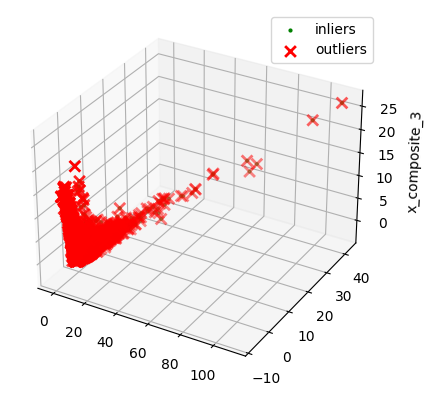

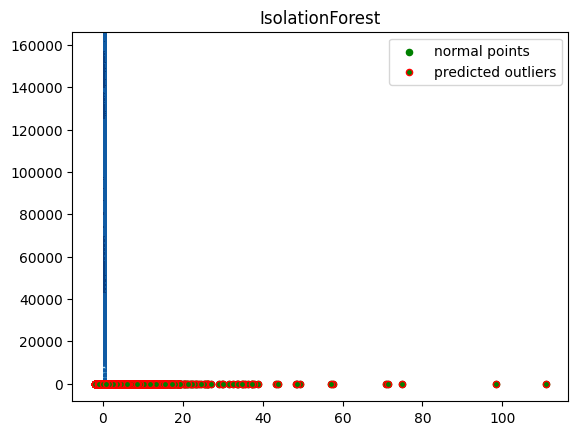

Evaluating model LocalOutlierFactor


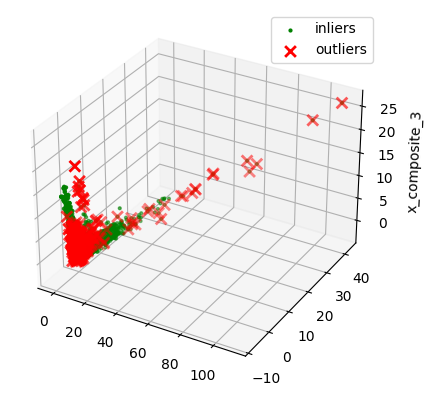

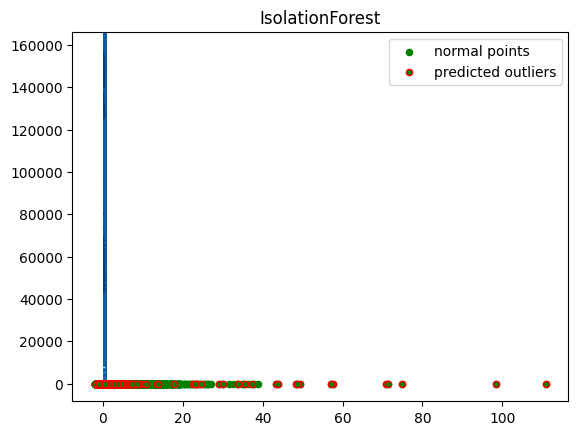

Evaluating model OneClassSVM


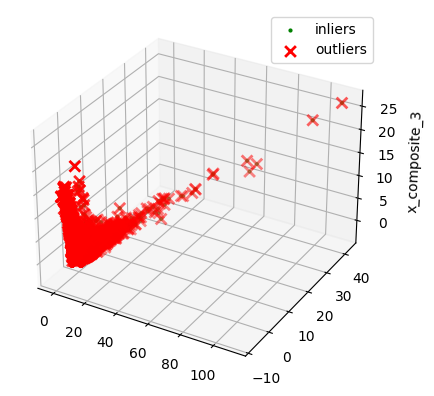

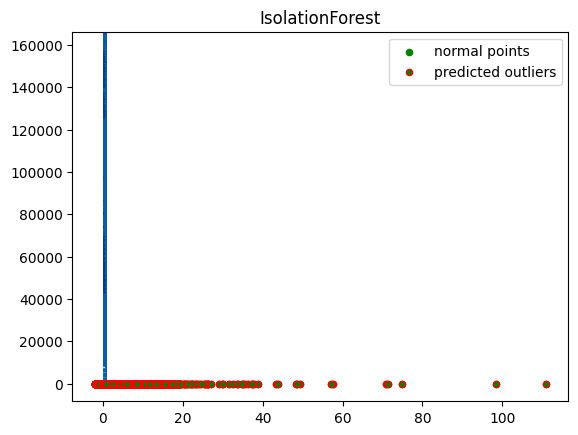

Evaluating model Voting


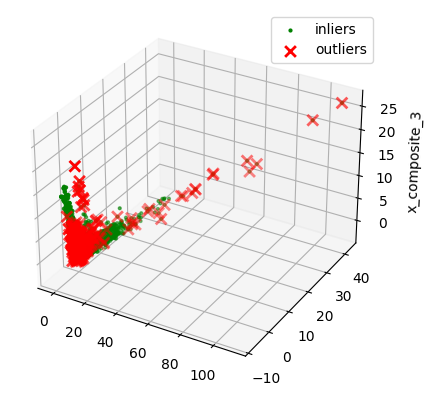

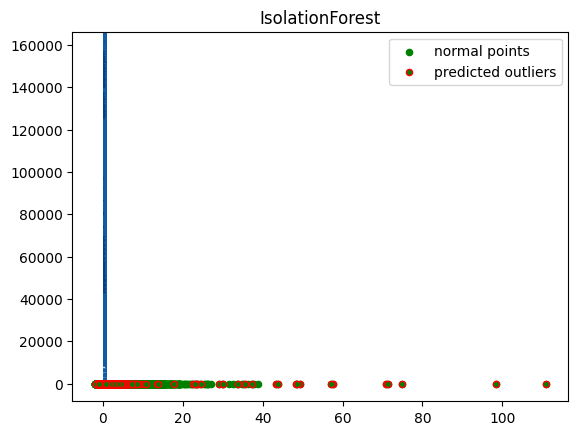

In [28]:
for anomalies_df in [[anomalies_df_IF, 'IsolationForest'], [anomalies_df_LOF, 'LocalOutlierFactor'], [anomalies_df_SVM, 'OneClassSVM'], [anomalies_df_voting, 'Voting']]:
    print('Evaluating model', anomalies_df[1])
    anomaly_model = anomalies_df[0]
    visualise(df_fraud, anomaly_model[anomaly_model.anomaly == -1].index)

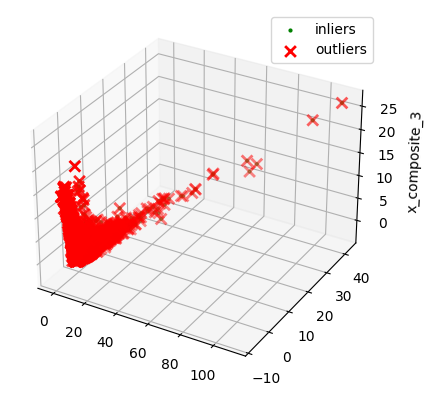

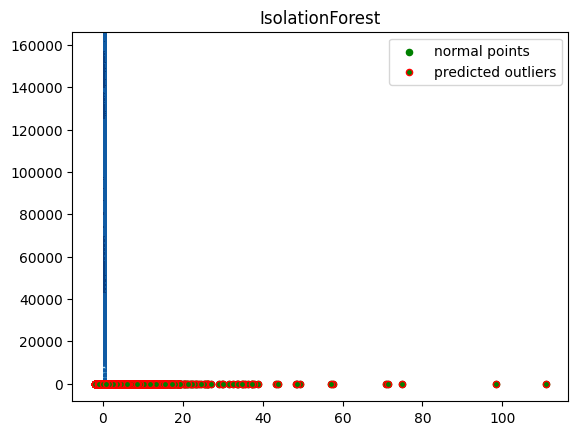

In [20]:
visualise(df_fraud, anomalies_df_IF[anomalies_df_IF.anomaly == -1].index)

## No model here out of the box is clearly the best. 
## OCSVM classify way too many points, and the other 2 also classify slightly too many points
## The good news, is all seem to pick off the obvious outliers
## So far the voting seems to be the best as it picks off obvious outliers but doe not flag of too many transactions

# Auto encoder

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load data (assuming it's stored in a numpy array called "data")
data = df_fraud

# Define the input shape
input_shape = (7,)

# Define the size of the encoded representation
encoding_dim = 3

# Define the input layer
input_layer = Input(shape=input_shape)

# Define the encoder layers
encoded = Dense(4, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)

# Define the decoder layers
decoded = Dense(4, activation="relu")(encoded)
decoded = Dense(input_shape[0], activation="sigmoid")(decoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer="adam", loss="mse")

# Train the model
autoencoder.fit(data, data, epochs=50, batch_size=32)

# Use the trained autoencoder to detect fraud
decoded_data = autoencoder.predict(data)
mse = np.mean(np.power(data - decoded_data, 2), axis=1)
threshold = np.percentile(mse, 95)
fraud_indices = np.where(mse > threshold)[0]
print("Detected fraud indices:", fraud_indices)

Epoch 1/50
5196/5196 [==============================] - 37s 6ms/step - loss: 0.9214
Epoch 2/50
5196/5196 [==============================] - 26s 5ms/step - loss: 0.8392
Epoch 3/50
5196/5196 [==============================] - 29s 6ms/step - loss: 0.8103
Epoch 4/50
5196/5196 [==============================] - 27s 5ms/step - loss: 0.8071
Epoch 5/50
5196/5196 [==============================] - 21s 4ms/step - loss: 0.8057
Epoch 6/50
5196/5196 [==============================] - 29s 6ms/step - loss: 0.8048
Epoch 7/50
5196/5196 [==============================] - 26s 5ms/step - loss: 0.8043
Epoch 8/50
5196/5196 [==============================] - 25s 5ms/step - loss: 0.8036
Epoch 9/50
5196/5196 [==============================] - 36s 7ms/step - loss: 0.8032
Epoch 10/50
5196/5196 [==============================] - 22s 4ms/step - loss: 0.8027
Epoch 11/50
5196/5196 [==============================] - 26s 5ms/step - loss: 0.8025
Epoch 12/50
5196/5196 [==============================] - 21s 4ms/step - lo

In [236]:
potential_frauds

,Amount,Decimal_time,weekday,Trend,Time_diff,percentile_of_business
0,-7.502333,-2.552376,-1.463070,0.177120,-0.669006,-2.166367
1,-7.043132,-2.552376,-1.463070,0.177120,-0.669006,-2.166367
2,-4.287927,-2.552376,-1.463070,0.177120,-0.669006,-2.166367
3,-5.206329,-2.552376,-1.463070,0.177120,-0.669006,-2.166367
4,-6.813531,-2.552376,-1.463070,0.177120,-0.669006,-2.166367
...,...,...,...,...,...,...
165212,0.214629,0.027846,0.683494,0.226459,6.391187,0.048045
165373,-0.319330,0.718246,0.683494,0.225731,13.928463,0.048045
165459,0.189465,0.256029,0.683494,0.200981,7.695428,0.048045
166027,0.001560,1.036141,0.683494,0.204705,7.026231,0.048045


# EM MV Testing

IsolationForest processing...
LocalOutlierFactor processing...
OneClassSVM processing...

 failed to achieve t_max 


 failed to achieve t_max 



<Figure size 640x480 with 0 Axes>

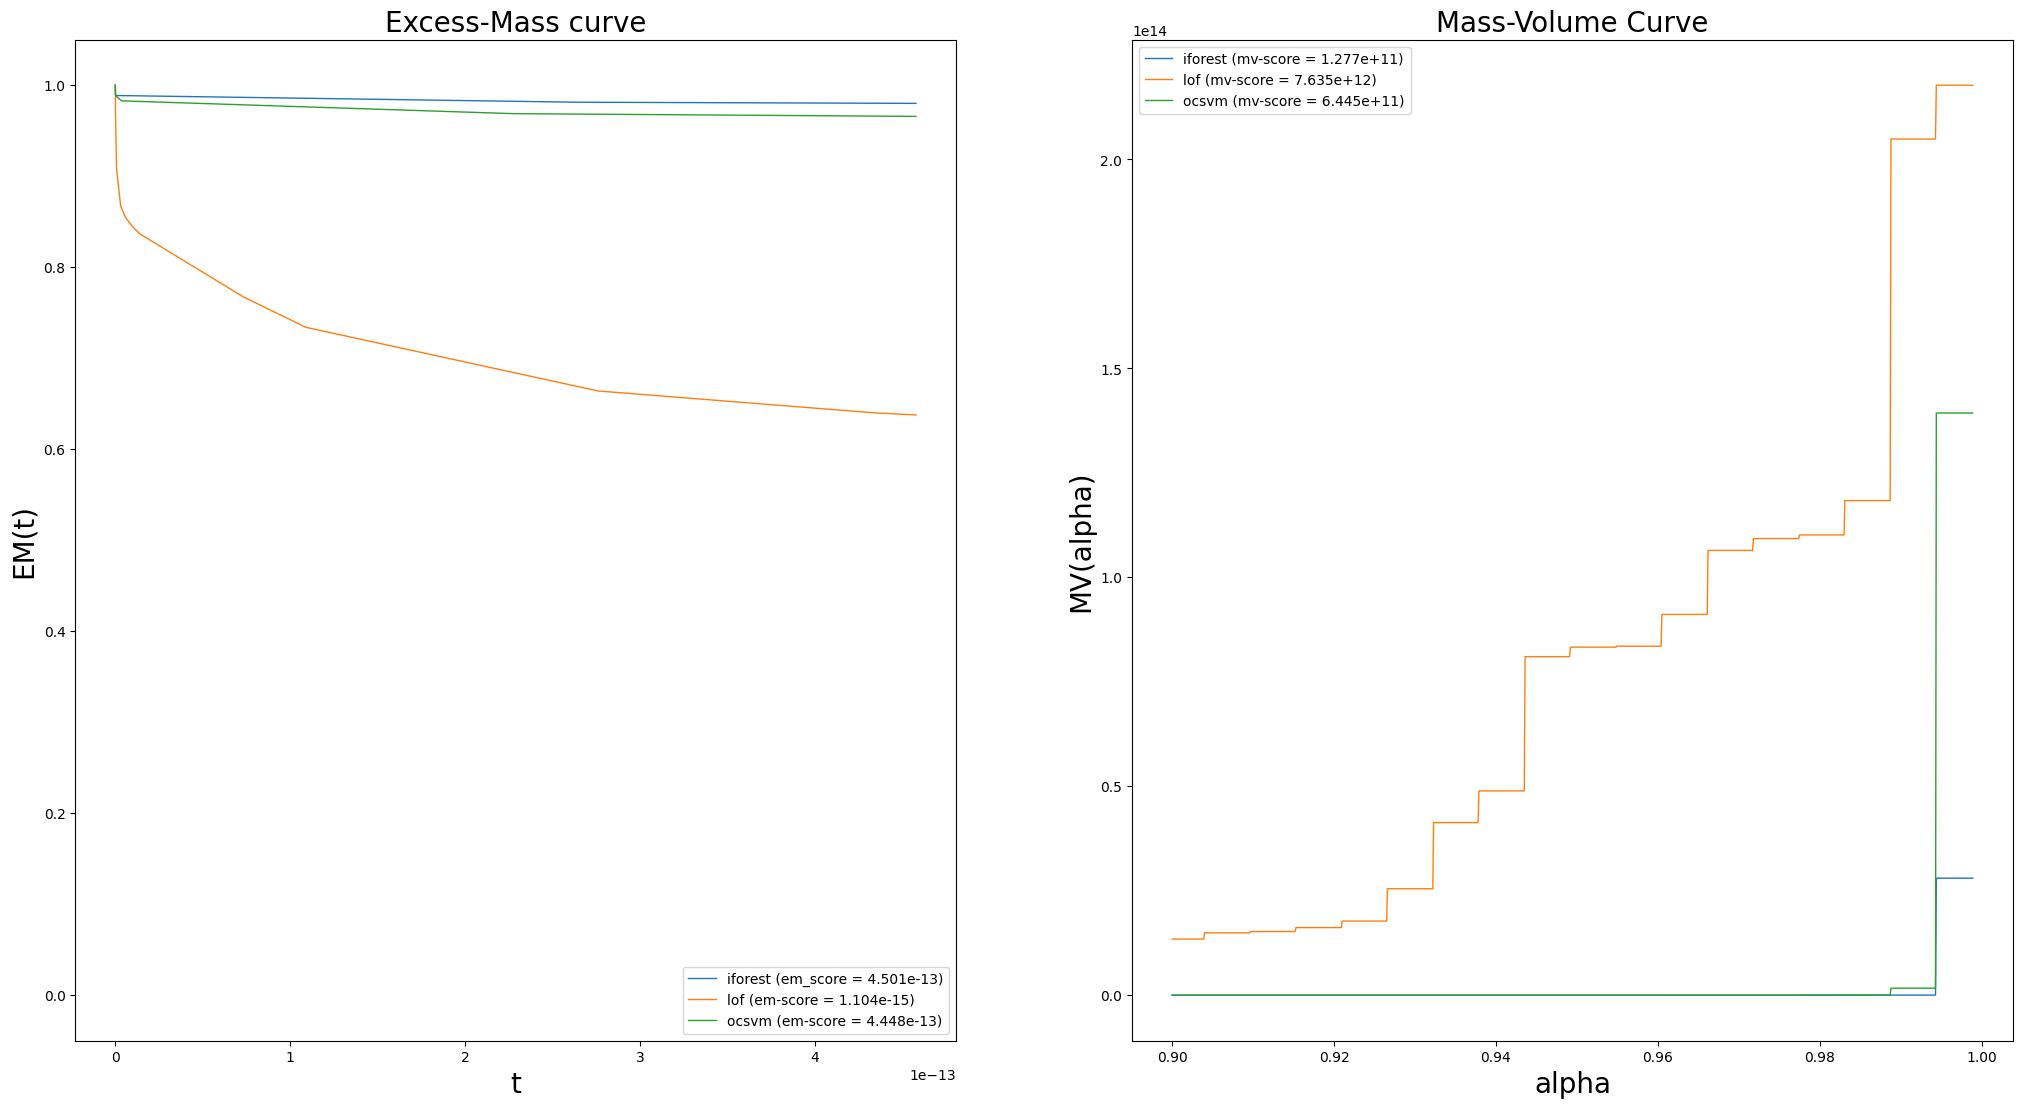

IsolationForest processing...
LocalOutlierFactor processing...
OneClassSVM processing...

 failed to achieve t_max 


 failed to achieve t_max 



KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

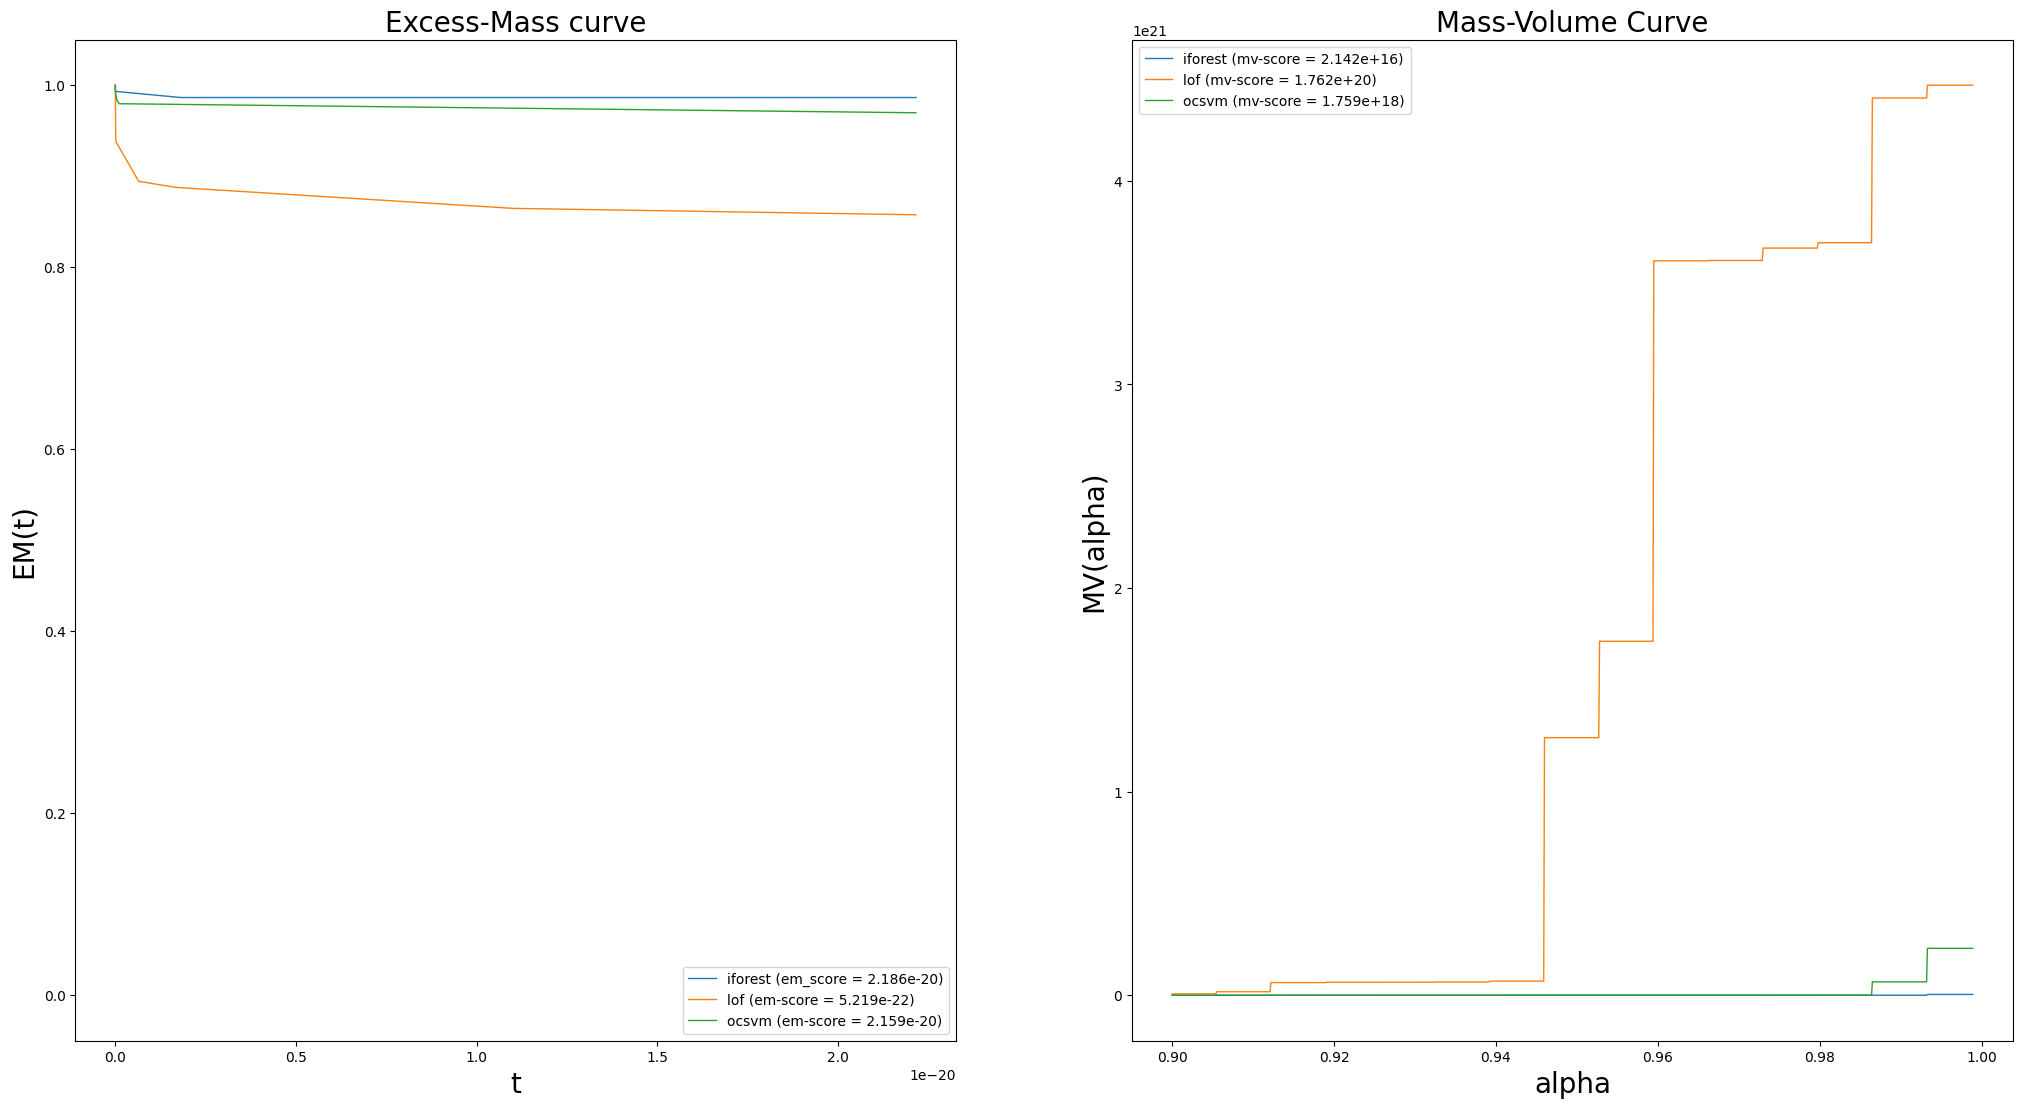

In [35]:
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np

from em import em, mv
df_fraud = df.drop(['Account', 'to_account', 'to_name', 'Date', 'Time', 'Transaction_ID', 'Employment', 'Day', 'Month', 'Income'], axis=1)
scores = {'em':[0,0,0], 'mv':[0,0,0]}

for account in df['Account'].sample(10):
        temp = df_fraud[df.Account == account]
        temp = temp.loc[:, (temp != 0).any(axis=0)]
        std_scale = preprocessing.StandardScaler().fit(temp)
        train_norm = std_scale.transform(temp)
        training_norm_col = pd.DataFrame(train_norm, index=temp.index, columns=temp.columns) 
        temp.update(training_norm_col)
        # parameters of the algorithm:
        n_generated = 100000
        alpha_min = 0.9
        alpha_max = 0.999
        t_max = 0.9
        ocsvm_max_train = 10000

        np.random.seed(1)

        plt.clf()
        plt.figure(figsize=(25, 13))

        # loading and vectorization
        X= np.array(temp)

        n_samples, n_features = np.shape(X)
        n_samples_train = n_samples // 2
        n_samples_test = n_samples - n_samples_train

        X_train = X[:n_samples_train, :]
        X_test = X[n_samples_test:, :]

        # define models:
        iforest = IsolationForest()
        lof = LocalOutlierFactor(n_neighbors=20)
        ocsvm = OneClassSVM()

        lim_inf = X.min(axis=0)
        lim_sup = X.max(axis=0)
        volume_support = (lim_sup - lim_inf).prod()
        t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                size=(n_generated, n_features))

        # fit:
        print('IsolationForest processing...')
        iforest = IsolationForest()
        iforest.fit(X_train)
        s_X_iforest = iforest.decision_function(X_test)
        print('LocalOutlierFactor processing...')
        lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
        lof.fit(X_train)
        s_X_lof = lof.decision_function(X_test)
        print('OneClassSVM processing...')
        ocsvm = OneClassSVM()
        ocsvm.fit(X_train[:min(ocsvm_max_train, n_samples_train - 1)])
        s_X_ocsvm = ocsvm.decision_function(X_test).reshape(1, -1)[0]
        s_unif_iforest = iforest.decision_function(unif)
        s_unif_lof = lof.decision_function(unif)
        s_unif_ocsvm = ocsvm.decision_function(unif).reshape(1, -1)[0]
        plt.subplot(121)
        auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                                volume_support,
                                                s_unif_iforest,
                                                s_X_iforest, n_generated)

        auc_lof, em_lof, amax_lof = em(t, t_max, volume_support,
                                        s_unif_lof, s_X_lof, n_generated)

        auc_ocsvm, em_ocsvm, amax_ocsvm = em(t, t_max, volume_support,
                                                s_unif_ocsvm, s_X_ocsvm,
                                                n_generated)
        if amax_iforest == -1 or amax_lof == -1 or amax_ocsvm == -1:
                amax = -1
        else:
                amax = max(amax_iforest, amax_lof, amax_ocsvm)
        plt.subplot(121)
        plt.plot(t[:amax], em_iforest[:amax], lw=1,
                label='%s (em_score = %0.3e)'
                % ('iforest', auc_iforest))
        plt.plot(t[:amax], em_lof[:amax], lw=1,
                label='%s (em-score = %0.3e)'
                % ('lof', auc_lof))
        plt.plot(t[:amax], em_ocsvm[:amax], lw=1,
                label='%s (em-score = %0.3e)'
                % ('ocsvm', auc_ocsvm))
        mylist1 = [auc_iforest, auc_lof, auc_ocsvm]
        scores['em'][mylist1.index(max(mylist1))]+=1
        plt.ylim([-0.05, 1.05])
        plt.xlabel('t', fontsize=20)
        plt.ylabel('EM(t)', fontsize=20)
        plt.title('Excess-Mass curve', fontsize=20)
        plt.legend(loc="lower right")


        plt.subplot(122)
        auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                        s_unif_iforest, s_X_iforest, n_generated)
        auc_lof, mv_lof = mv(axis_alpha, volume_support,
                                s_unif_lof, s_X_lof, n_generated)
        auc_ocsvm, mv_ocsvm = mv(axis_alpha, volume_support,
                                s_unif_ocsvm, s_X_ocsvm, n_generated)
        plt.plot(axis_alpha, mv_iforest, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('iforest', auc_iforest))
        plt.plot(axis_alpha, mv_lof, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('lof', auc_lof))
        plt.plot(axis_alpha, mv_ocsvm, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('ocsvm', auc_ocsvm))
        mylist1 = [auc_iforest, auc_lof, auc_ocsvm]
        scores['mv'][mylist1.index(max(mylist1))]+=1
        # plt.xlim([-0.05, 1.05])
        # plt.ylim([-0.05, 100])
        plt.xlabel('alpha', fontsize=20)
        plt.ylabel('MV(alpha)', fontsize=20)
        plt.title('Mass-Volume Curve', fontsize=20)
        plt.legend(loc="upper left")

        plt.savefig('unsup_mv_em__unsupervised_09_factorized')
        plt.savefig('mv_em__unsupervised_09_factorized')

        plt.savefig('mv_em__supervised'
                + '_alphamin' + str(int(100 * alpha_min)) + '_'
                + '_n_generated' + str(n_generated) + '_'
                + '_ocsvm' + str(ocsvm_max_train) + '_'
                + '_factorized_pruning')

        plt.show()

print(scores)

In [ ]:
def test_iforest(params, temp):
        n_generated = 100000
        alpha_min = 0.9
        alpha_max = 0.999
        t_max = 0.9
        ocsvm_max_train = 10000

        np.random.seed(1)

        plt.clf()
        plt.figure(figsize=(25, 13))

        # loading and vectorization
        X= np.array(temp)

        n_samples, n_features = np.shape(X)
        n_samples_train = n_samples // 2
        n_samples_test = n_samples - n_samples_train

        X_train = X[:n_samples_train, :]
        X_test = X[n_samples_test:, :]

        # define models:
        iforest = IsolationForest(params)

        lim_inf = X.min(axis=0)
        lim_sup = X.max(axis=0)
        volume_support = (lim_sup - lim_inf).prod()
        t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                size=(n_generated, n_features))

        # fit:
        print('IsolationForest processing...')
        iforest = IsolationForest()
        iforest.fit(X_train)
        s_X_iforest = iforest.decision_function(X_test)
 
        s_unif_iforest = iforest.decision_function(unif)
        plt.subplot(121)
        em_auc_iforest, em_iforest, amax_iforest = em(t, t_max,
                                                volume_support,
                                                s_unif_iforest,
                                                s_X_iforest, n_generated)


 
        amax = amax_iforest
        plt.subplot(121)
        plt.plot(t[:amax], em_iforest[:amax], lw=1,
                label='%s (em_score = %0.3e)'
                % ('iforest', em_auc_iforest))

        plt.ylim([-0.05, 1.05])
        plt.xlabel('t', fontsize=20)
        plt.ylabel('EM(t)', fontsize=20)
        plt.title('Excess-Mass curve', fontsize=20)
        plt.legend(loc="lower right")


        plt.subplot(122)
        mv_auc_iforest, mv_iforest = mv(axis_alpha, volume_support,
                                        s_unif_iforest, s_X_iforest, n_generated)

        plt.plot(axis_alpha, mv_iforest, lw=1,
                label='%s (mv-score = %0.3e)'
                % ('iforest', mv_auc_iforest))

        # plt.xlim([-0.05, 1.05])
        # plt.ylim([-0.05, 100])
        plt.xlabel('alpha', fontsize=20)
        plt.ylabel('MV(alpha)', fontsize=20)
        plt.title('Mass-Volume Curve', fontsize=20)
        plt.legend(loc="upper left")


        plt.show()

        return(em_auc_iforest, mv_auc_iforest)
